In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

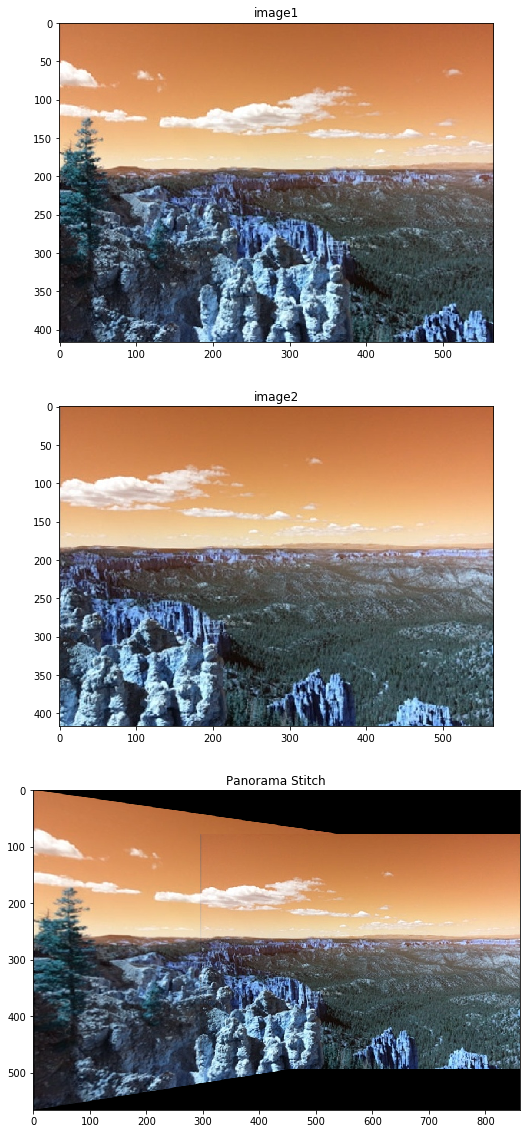

In [2]:
def stitch(image1, image2, homography_matrix):
    r1, c1 = image1.shape[:2]
    r2, c2 = image2.shape[:2]
    
    pts1 = np.float32([[0, 0], [0, r1], [c1, r1], [c1, 0]]).reshape(-1, 1, 2)
    pts2 = cv2.perspectiveTransform(
        np.float32([[0, 0], [0, r2], [c2, r2], [c2, 0]]).reshape(-1, 1, 2),
        homography_matrix
    )
    
    pts = np.concatenate((pts1, pts2), axis=0)
    
    x_min, y_min = np.int32(pts.min(axis=0).ravel() - 0.5)
    x_max, y_max = np.int32(pts.max(axis=0).ravel() + 0.5)
    
    translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]])
    
    out = cv2.warpPerspective(image2, translation.dot(homography_matrix), (x_max - x_min, y_max - y_min))
    out[-y_min : r1 - y_min, -x_min : c1 - x_min] = image1
    
    return out

image1 = cv2.imread("../resources/stitch1.jpg")
image2 = cv2.imread("../resources/stitch2.jpg")

sift = cv2.xfeatures2d.SIFT_create()
kp1, desc1 = sift.detectAndCompute(cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY), mask=None)
kp2, desc2 = sift.detectAndCompute(cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY), mask=None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 10)
search_params = dict(checks = 150)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)
good_matches = []

for (k1, k2) in matches:
    if k1.distance < 0.6 * k2.distance: good_matches.append(k1)

assert(len(good_matches) > 15)

src_pts = np.float32([kp1[k.queryIdx].pt for k in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[k.trainIdx].pt for k in good_matches]).reshape(-1, 1, 2)

ret, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
out = stitch(image2, image1, ret)

fig = plt.figure()
fig.set_size_inches(20, 20)

fig.add_subplot(3, 1, 1); plt.title("image1"); plt.imshow(image1)
fig.add_subplot(3, 1, 2); plt.title("image2"); plt.imshow(image2)
fig.add_subplot(3, 1, 3); plt.title("Panorama Stitch"); plt.imshow(out)

plt.show()